# Imports & data loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.model_selection import train_test_split, cross_val_score, KFold, learning_curve, cross_val_predict
from sklearn.metrics import confusion_matrix,plot_roc_curve, plot_confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.impute import SimpleImputer, KNNImputer
from lightgbm import LGBMClassifier
import itertools
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import requests
import json
import time

/Users/elros/miniconda3/envs/ds/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
rain = pd.read_csv('data/rain_data_aus.csv')

In [3]:
rain.head(5)

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,humidity9am,humidity3pm,pressure9am,...,temp9am,temp3pm,raintoday,amountOfRain,raintomorrow,temp,humidity,precipitation3pm,precipitation9am,modelo_vigente
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,71.0,22.0,1007.7,...,16.9,21.8,No,0.0,No,29.48,28.400000,12,5.115360,0.089825
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,44.0,25.0,1010.6,...,17.2,24.3,No,0.0,No,32.12,2.208569,10,21.497100,0.023477
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,38.0,30.0,1007.6,...,21.0,23.2,No,0.0,No,32.84,38.000000,17,20.782859,0.027580
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,45.0,16.0,1017.6,...,18.1,26.5,No,1.0,No,35.60,21.200000,8,12.028646,0.023962
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,82.0,33.0,1010.8,...,17.8,29.7,No,0.2,No,40.76,41.600000,9,11.883546,0.220164


# Possible additional features

## Wind

In [4]:
wind = pd.read_csv('data/wind_table_01.csv')

In [5]:
wind = wind.append([pd.read_csv('data/wind_table_02.csv'),
            pd.read_csv('data/wind_table_03.csv'),
            pd.read_csv('data/wind_table_04.csv'),
            pd.read_csv('data/wind_table_05.csv'),
            pd.read_csv('data/wind_table_06.csv'),
            pd.read_csv('data/wind_table_07.csv'),
            pd.read_csv('data/wind_table_08.csv'),])

In [6]:
wind.head(5)

,date,location,wind_gustdir,wind_gustspeed,wind_dir9am,wind_dir3pm,wind_speed9am,wind_speed3pm,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm
0,2007-11-01,Canberra,NW,30.0,SW,NW,6.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-11-02,Canberra,ENE,39.0,E,W,4.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2007-11-03,Canberra,NW,85.0,N,NNE,6.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2007-11-04,Canberra,NW,54.0,WNW,W,30.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2007-11-05,Canberra,SSE,50.0,SSE,ESE,20.0,28.0,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
wind.drop_duplicates(subset=wind.columns, inplace=True)
rain = rain.merge(wind, on=['location','date'])

## Latitude and Longitude

In [8]:
rain['location'].unique()

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

In [9]:
lat_lon = {
    'BadgerysCreek' : (-33.879377528357345, 150.76062423421945),
    'Albury' : (-36.07383198870718, 146.91296901711635),
    'Cobar' : (-31.487939903735267, 145.84463868626563),
    'CoffsHarbour' : (-30.29718757178068, 153.11526710392258),
    'Moree' : (-29.440216080649265, 149.83353604961772),
    'NorfolkIsland' : (-29.036673284583994, 167.9552915013074),
    'Sydney' : (-33.89011666916285, 151.11184106092688),
    'SydneyAirport' : (-33.939653693766466, 151.1758943735156),
    'WaggaWagga' : (-35.10634530967798, 147.3604314637853),
    'Williamtown' : (-37.86116925122329, 144.88969672047764),
    'Canberra' : (-35.29755690827428, 149.12692934564876),
    'Sale' : (-38.10053145619689, 147.07314295588353),
    'MelbourneAirport' : (-37.669639531602726, 144.84145828525055),
    'Melbourne' : (-37.81887701386994, 144.9957392412022),
    'Mildura' : (-34.20873358167369, 142.13051228338728),
    'Portland' : (-38.352152587261116, 141.60565367749297),
    'Watsonia' : (-37.70920479895751, 145.082558129801),
    'Brisbane' : (-27.49033507781788, 153.04896863426117),
    'Cairns' : (-16.929355308139346, 145.74777869972905),
    'Townsville' : (-19.274469532193546, 146.7690528593378),
    'MountGambier' : (-37.821813333187244, 140.78090825776917),
    'Nuriootpa' : (-34.469086037136734, 138.99299960851346),
    'Woomera' : (-31.196952532415747, 136.82582109960006),
    'Albany' : (-35.020731963138495, 117.88343760805337),
    'PerthAirport' : (-31.939609000908586, 115.96683961930746),
    'Perth' : (-31.94173404955837, 115.83613290693711),
    'Hobart' : (-42.88255999036971, 147.32739760794198),
    'AliceSprings' : (-23.697938533987184, 133.88120279738044),
    'Darwin' : (-12.382344526724662, 130.87996886959004),
    'Newcastle' : (-32.931435427713225, 151.75021194376723),
    'NorahHead' : (-33.281774853636925, 151.5670017932749),
    'Penrith' : (-33.752196848268426, 150.6946825633104),
    'Richmond' : (-33.59979119907803, 150.75232332046352),
    'Wollongong' : (-34.427814011356915, 150.88891379743123),
    'Tuggeranong' : (-35.41042738809596, 149.10187301160292),
    'MountGinini' : (-35.52905700334009, 148.77245206855258),
    'Ballarat' : (-37.562566695304994, 143.8528621487283),
    'Bendigo' : (-36.75549153225249, 144.2796392480247),
    'Nhil' : (-36.33362057245178, 141.65025804158452),
    'Dartmoor' : (-37.9177149087168, 141.2761564745003),
    'GoldCoast' : (-28.014953647717725, 153.40059644566546),
    'Adelaide' : (-34.92160135508944, 138.600025787353),
    'Witchcliffe' : (-34.01642120619706, 115.09728337170588),
    'PearceRAAF' : (-31.66733723316479, 116.02928581313837),
    'SalmonGums' : (-32.959121561602196, 121.631584982849),
    'Walpole' : (-34.97747017517623, 116.73707906563985),
    'Launceston' : (-41.42700212198398, 147.14435998630626),
    'Katherine' : (-14.463566306610936, 132.266118595156),
    'Uluru' : (-25.34433831484179, 131.03688832238223)
}

According to [this](https://datascience.stackexchange.com/questions/13567/ways-to-deal-with-longitude-latitude-feature) answer in data science stackexchange we can "normalize" lat and lon in 3 dimension variables using sine and cosine:

In [10]:
rain['lat'] = rain['location'].map(lambda x: lat_lon[x][0])
rain['lon'] = rain['location'].map(lambda x: lat_lon[x][1])
rain['x'] = np.cos(rain['lat']) * np.cos(rain['lon'])
rain['y'] = np.cos(rain['lat']) * np.sin(rain['lon'])
rain['z'] = np.sin(rain['lat'])

## Distance to coastline

<img src="img/rainfall-distribution.png">
The distance to the ocean seems to be important!

[Source](https://www.researchgate.net/publication/250119451_Stress_Tolerance_and_Persistence_of_Perennial_Grasses_The_Role_of_the_Summer_Dormancy_Trait_in_Temperate_Australia)

In [11]:
#distance_to_coast = {}

Used [this API](https://www.kbgeo.com/) to get the distance to the coastline in miles from a point using latitude and longitude

In [12]:
'''
for location in lat_lon.keys():
    lat = lat_lon[location][0]
    lon = lat_lon[location][1]
    r = requests.get('https://api.kbgeo.com/coastal-distance/v2/coord?lat=' + str(lat) + '&lng=' + str(lon),
                 headers={'kb-auth-token': 'd1aa5373-2c45-4392-b863-8a232fd50fba'})
    distance_to_coast[location] = json.loads(r.content)['distanceInMiles']
    time.sleep(5)
dist_coast_file = open("data/distance_coast.json", "w")
json.dump(distance_to_coast, dist_coast_file)
dist_coast_file.close()
'''

'\nfor location in lat_lon.keys():\n    lat = lat_lon[location][0]\n    lon = lat_lon[location][1]\n    r = requests.get(\'https://api.kbgeo.com/coastal-distance/v2/coord?lat=\' + str(lat) + \'&lng=\' + str(lon),\n                 headers={\'kb-auth-token\': \'d1aa5373-2c45-4392-b863-8a232fd50fba\'})\n    distance_to_coast[location] = json.loads(r.content)[\'distanceInMiles\']\n    time.sleep(5)\ndist_coast_file = open("data/distance_coast.json", "w")\njson.dump(distance_to_coast, dist_coast_file)\ndist_coast_file.close()\n'

In [13]:
dist_coast_file = open("data/distance_coast.json", "r")
distance_to_coast = json.loads(dist_coast_file.read())
dist_coast_file.close()

In [14]:
rain['distanceToCoast'] = rain['location'].map(distance_to_coast)

In [15]:
rain['distanceToCoast'].sample(10)

60157      18.761
2367      129.486
48249      62.418
109506      5.901
5053       17.422
73976       0.434
15062       0.849
58972      82.962
51402      78.894
36554     190.369
Name: distanceToCoast, dtype: float64

## Seasons/Month

In [16]:
rain['month'] = pd.DatetimeIndex(rain['date']).month

In [17]:
rain['summer'] = pd.DatetimeIndex(rain['date']).month.isin([12,1,2])
rain['fall'] = pd.DatetimeIndex(rain['date']).month.isin([3,4,5])
rain['winter'] = pd.DatetimeIndex(rain['date']).month.isin([6,7,8])
rain['spring'] = pd.DatetimeIndex(rain['date']).month.isin([9,10,11])

# Data Cleaning

Drop the previous model, amount of rain, location, lat, lon and date since we won't use them:

In [18]:
rain.drop(['modelo_vigente','amountOfRain','location','lat','lon','date'],axis='columns',inplace=True)

Check the nulls:

In [61]:
rain.isnull().sum() * 100 / len(rain)

mintemp            0.447983
maxtemp            0.226453
rainfall           0.988797
evaporation       42.789026
sunshine          47.692924
                    ...    
winddir3pm_SSW     0.000000
winddir3pm_SW      0.000000
winddir3pm_W       0.000000
winddir3pm_WNW     0.000000
winddir3pm_WSW     0.000000
Length: 61, dtype: float64

## Categorical

In [20]:
rain["raintoday"].replace({"No": 0, "Yes": 1}, inplace=True)
rain["raintomorrow"].replace({"No": 0, "Yes": 1}, inplace=True)

In [21]:
windir = rain[['wind_gustdir','wind_dir9am','wind_dir3pm','windgustdir','winddir9am','winddir3pm']]
rain = pd.concat([rain,pd.get_dummies(windir)],axis=1)

In [22]:
rain.drop([x for x in rain.columns if 'wind_dir' in x or 'gustdir' in x], axis='columns', inplace=True)

In [23]:
rain = pd.concat([rain,pd.get_dummies(rain[['month']])],axis=1)

In [24]:
rain.drop(['month','winddir9am','winddir3pm'], axis='columns', inplace=True)

# EDA

## Correlation with target

<AxesSubplot:>

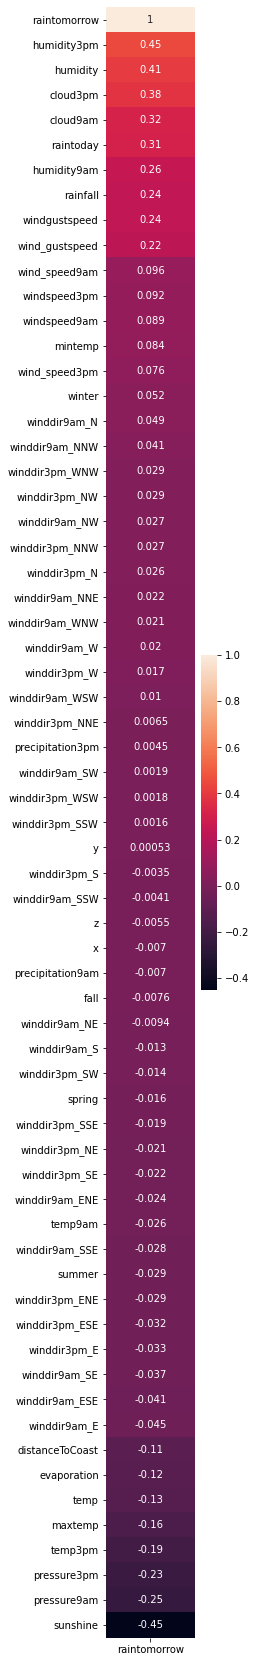

In [25]:
plt.figure(figsize=(2,30))
sns.heatmap(rain.corr()[['raintomorrow']].sort_values('raintomorrow',ascending=False),annot=True)

## Boxplots

<AxesSubplot:xlabel='raintomorrow', ylabel='precipitation3pm'>

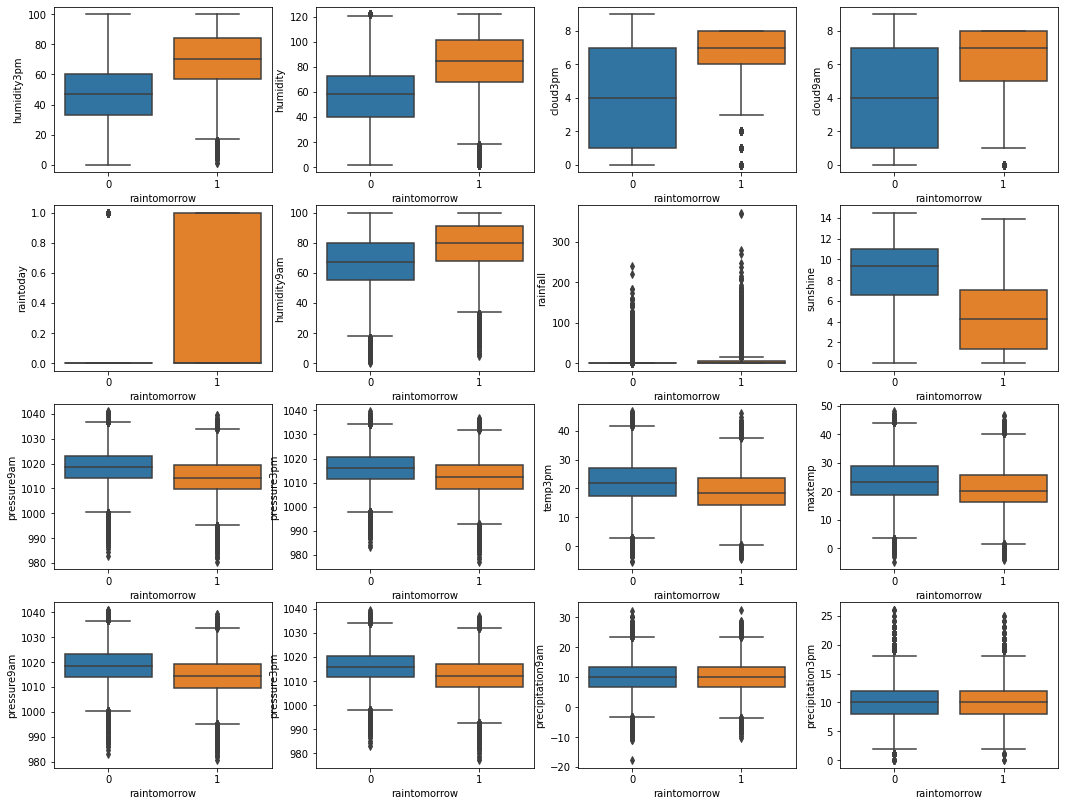

In [26]:
fig, axes = plt.subplots(4,4,figsize=(18,14))
sns.boxplot(data=rain,  x='raintomorrow', y='humidity3pm', ax=axes[0][0])
sns.boxplot(data=rain,  x='raintomorrow', y='humidity', ax=axes[0][1])
sns.boxplot(data=rain,  x='raintomorrow', y='cloud3pm', ax=axes[0][2])
sns.boxplot(data=rain,  x='raintomorrow', y='cloud9am', ax=axes[0][3])
sns.boxplot(data=rain,  x='raintomorrow', y='raintoday', ax=axes[1][0])
sns.boxplot(data=rain,  x='raintomorrow', y='humidity9am', ax=axes[1][1])
sns.boxplot(data=rain,  x='raintomorrow', y='rainfall', ax=axes[1][2])
sns.boxplot(data=rain,  x='raintomorrow', y='sunshine', ax=axes[1][3])
sns.boxplot(data=rain,  x='raintomorrow', y='pressure9am', ax=axes[2][0])
sns.boxplot(data=rain,  x='raintomorrow', y='pressure3pm', ax=axes[2][1])
sns.boxplot(data=rain,  x='raintomorrow', y='temp3pm', ax=axes[2][2])
sns.boxplot(data=rain,  x='raintomorrow', y='maxtemp', ax=axes[2][3])
sns.boxplot(data=rain,  x='raintomorrow', y='evaporation', ax=axes[3][0])
sns.boxplot(data=rain,  x='raintomorrow', y='distanceToCoast', ax=axes[3][1])
sns.boxplot(data=rain,  x='raintomorrow', y='wind_gustspeed', ax=axes[3][2])
sns.boxplot(data=rain,  x='raintomorrow', y='windgustspeed', ax=axes[3][3])

In [27]:
#rain.drop(['precipitation9am','precipitation3pm','pressure9am','pressure3pm'], axis='columns', inplace=True)

# Models

## Baseline (logistic)

In [28]:
rain_baseline = rain.copy()
rain_baseline.drop([x for x in rain_baseline.columns if 'winddir' in x], axis='columns', inplace=True)
X_bl = rain_baseline.loc[:, rain_baseline.columns != 'raintomorrow']
y_bl = rain_baseline['raintomorrow']
X_bl_train, X_bl_test, y_bl_train, y_bl_test = train_test_split(X_bl, y_bl, test_size=0.2, stratify=y_bl)

### Outliers

In [29]:
'''
X_bl_train = pd.DataFrame(X_bl_train)
X_bl_train.columns = X_bl.columns
X_bl_train['raintomorrow'] = y_bl_train
X_bl_test = pd.DataFrame(X_bl_test)
X_bl_test.columns = X_bl.columns
X_bl_test['raintomorrow'] = y_bl_test
'''

"\nX_bl_train = pd.DataFrame(X_bl_train)\nX_bl_train.columns = X_bl.columns\nX_bl_train['raintomorrow'] = y_bl_train\nX_bl_test = pd.DataFrame(X_bl_test)\nX_bl_test.columns = X_bl.columns\nX_bl_test['raintomorrow'] = y_bl_test\n"

In [30]:
'''
q25 = rain_baseline.loc[rain_baseline['raintomorrow'] == 1,'humidity3pm'].quantile(0.25)
X_bl_train.loc[(X_bl_train['humidity3pm'] < q25) & X_bl_train['raintomorrow'] == 1,'humidity3pm'] = X_bl_train.humidity3pm.mean()
X_bl_test.loc[(X_bl_test['humidity3pm'] < q25) & X_bl_test['raintomorrow'] == 1,'humidity3pm'] = X_bl_train.humidity3pm.mean()

q25 = rain_baseline.loc[rain_baseline['raintomorrow'] == 1,'humidity'].quantile(0.25)
q75 = rain_baseline.loc[rain_baseline['raintomorrow'] == 0,'humidity'].quantile(0.75)
X_bl_train.loc[(X_bl_train['humidity'] < q25) & X_bl_train['raintomorrow'] == 1,'humidity'] = X_bl_train.humidity.mean()
X_bl_train.loc[(X_bl_train['humidity'] > q75) & X_bl_train['raintomorrow'] == 0,'humidity'] = X_bl_train.humidity.mean()
X_bl_test.loc[(X_bl_test['humidity'] < q25) & X_bl_test['raintomorrow'] == 1,'humidity'] = X_bl_train.humidity.mean()
X_bl_test.loc[(X_bl_test['humidity'] > q75) & X_bl_test['raintomorrow'] == 0,'humidity'] = X_bl_train.humidity.mean()

q25 = rain_baseline.loc[rain_baseline['raintomorrow'] == 1,'cloud3pm'].quantile(0.25)
X_bl_train.loc[(X_bl_train['cloud3pm'] < q25) & X_bl_train['raintomorrow'] == 1,'cloud3pm'] = X_bl_train.cloud3pm.mean()
X_bl_test.loc[(X_bl_train['cloud3pm'] < q25) & X_bl_test['raintomorrow'] == 1,'cloud3pm'] = X_bl_train.cloud3pm.mean()

q25 = rain_baseline.loc[rain_baseline['raintomorrow'] == 1,'cloud9am'].quantile(0.25)
X_bl_train.loc[(X_bl_train['cloud9am'] < q25) & X_bl_train['raintomorrow'] == 1,'cloud9am'] = X_bl_train.cloud9am.mean()
X_bl_test.loc[(X_bl_train['cloud9am'] < q25) & X_bl_test['raintomorrow'] == 1,'cloud9am'] = X_bl_train.cloud9am.mean()

q75 = rain_baseline.loc[rain_baseline['raintomorrow'] == 0,'raintoday'].quantile(0.75)
X_bl_train.loc[(X_bl_train['raintoday'] < q25) & X_bl_train['raintomorrow'] == 0,'raintoday'] = X_bl_train.raintoday.mean()
X_bl_test.loc[(X_bl_train['raintoday'] < q25) & X_bl_test['raintomorrow'] == 0,'raintoday'] = X_bl_train.raintoday.mean()
'''

"\nq25 = rain_baseline.loc[rain_baseline['raintomorrow'] == 1,'humidity3pm'].quantile(0.25)\nX_bl_train.loc[(X_bl_train['humidity3pm'] < q25) & X_bl_train['raintomorrow'] == 1,'humidity3pm'] = X_bl_train.humidity3pm.mean()\nX_bl_test.loc[(X_bl_test['humidity3pm'] < q25) & X_bl_test['raintomorrow'] == 1,'humidity3pm'] = X_bl_train.humidity3pm.mean()\n\nq25 = rain_baseline.loc[rain_baseline['raintomorrow'] == 1,'humidity'].quantile(0.25)\nq75 = rain_baseline.loc[rain_baseline['raintomorrow'] == 0,'humidity'].quantile(0.75)\nX_bl_train.loc[(X_bl_train['humidity'] < q25) & X_bl_train['raintomorrow'] == 1,'humidity'] = X_bl_train.humidity.mean()\nX_bl_train.loc[(X_bl_train['humidity'] > q75) & X_bl_train['raintomorrow'] == 0,'humidity'] = X_bl_train.humidity.mean()\nX_bl_test.loc[(X_bl_test['humidity'] < q25) & X_bl_test['raintomorrow'] == 1,'humidity'] = X_bl_train.humidity.mean()\nX_bl_test.loc[(X_bl_test['humidity'] > q75) & X_bl_test['raintomorrow'] == 0,'humidity'] = X_bl_train.humidit

In [31]:
#X_bl_train.drop(['raintomorrow'], axis='columns', inplace=True)
#X_bl_test.drop(['raintomorrow'], axis='columns', inplace=True)

### Model

In [32]:
imputer = SimpleImputer(strategy='mean')
X_bl_train = imputer.fit_transform(X_bl_train)
X_bl_test = imputer.transform(X_bl_test)
scaler = StandardScaler()
X_bl_train = scaler.fit_transform(X_bl_train)
X_bl_test = scaler.transform(X_bl_test)

In [33]:
logistic = LogisticRegression()
logistic.fit(X_bl_train, y_bl_train)

LogisticRegression()

In [34]:
roc_auc_score(y_bl_test, logistic.predict_proba(X_bl_test)[:, 1])

0.8567994497291302

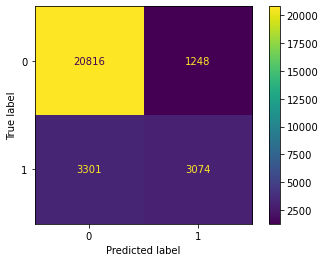

In [35]:
plot_confusion_matrix(logistic, X_bl_test, y_bl_test,values_format='d')

## LGBM

In [36]:
X = rain.loc[:, rain.columns != 'raintomorrow']
y = rain['raintomorrow']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

### Outliers

In [38]:
'''
X_train = pd.DataFrame(X_train)
X_train.columns = X.columns
X_train['raintomorrow'] = y_train
X_test = pd.DataFrame(X_test)
X_test.columns = X.columns
X_test['raintomorrow'] = y_test
'''

"\nX_train = pd.DataFrame(X_train)\nX_train.columns = X.columns\nX_train['raintomorrow'] = y_train\nX_test = pd.DataFrame(X_test)\nX_test.columns = X.columns\nX_test['raintomorrow'] = y_test\n"

In [39]:
'''
q25 = rain.loc[rain['raintomorrow'] == 1,'humidity3pm'].quantile(0.25)
X_train.loc[(X_train['humidity3pm'] < q25) & X_train['raintomorrow'] == 1,'humidity3pm'] = X_train.humidity3pm.mean()
X_test.loc[(X_test['humidity3pm'] < q25) & X_test['raintomorrow'] == 1,'humidity3pm'] = X_train.humidity3pm.mean()

q25 = rain.loc[rain['raintomorrow'] == 1,'humidity'].quantile(0.25)
q75 = rain.loc[rain['raintomorrow'] == 0,'humidity'].quantile(0.75)
X_train.loc[(X_train['humidity'] < q25) & X_train['raintomorrow'] == 1,'humidity'] = X_train.humidity.mean()
X_train.loc[(X_train['humidity'] > q75) & X_train['raintomorrow'] == 0,'humidity'] = X_train.humidity.mean()
X_test.loc[(X_test['humidity'] < q25) & X_test['raintomorrow'] == 1,'humidity'] = X_train.humidity.mean()
X_test.loc[(X_test['humidity'] > q75) & X_test['raintomorrow'] == 0,'humidity'] = X_train.humidity.mean()

q25 = rain.loc[rain['raintomorrow'] == 1,'cloud3pm'].quantile(0.25)
X_train.loc[(X_train['cloud3pm'] < q25) & X_train['raintomorrow'] == 1,'cloud3pm'] = X_train.cloud3pm.mean()
X_test.loc[(X_test['cloud3pm'] < q25) & X_test['raintomorrow'] == 1,'cloud3pm'] = X_train.cloud3pm.mean()

q25 = rain.loc[rain['raintomorrow'] == 1,'cloud9am'].quantile(0.25)
X_train.loc[(X_train['cloud9am'] < q25) & X_train['raintomorrow'] == 1,'cloud9am'] = X_train.cloud9am.mean()
X_test.loc[(X_test['cloud9am'] < q25) & X_test['raintomorrow'] == 1,'cloud9am'] = X_train.cloud9am.mean()

q75 = rain.loc[rain['raintomorrow'] == 0,'raintoday'].quantile(0.75)
X_train.loc[(X_train['raintoday'] < q25) & X_train['raintomorrow'] == 0,'raintoday'] = X_train.raintoday.mean()
X_test.loc[(X_test['raintoday'] < q25) & X_test['raintomorrow'] == 0,'raintoday'] = X_train.raintoday.mean()
'''

"\nq25 = rain.loc[rain['raintomorrow'] == 1,'humidity3pm'].quantile(0.25)\nX_train.loc[(X_train['humidity3pm'] < q25) & X_train['raintomorrow'] == 1,'humidity3pm'] = X_train.humidity3pm.mean()\nX_test.loc[(X_test['humidity3pm'] < q25) & X_test['raintomorrow'] == 1,'humidity3pm'] = X_train.humidity3pm.mean()\n\nq25 = rain.loc[rain['raintomorrow'] == 1,'humidity'].quantile(0.25)\nq75 = rain.loc[rain['raintomorrow'] == 0,'humidity'].quantile(0.75)\nX_train.loc[(X_train['humidity'] < q25) & X_train['raintomorrow'] == 1,'humidity'] = X_train.humidity.mean()\nX_train.loc[(X_train['humidity'] > q75) & X_train['raintomorrow'] == 0,'humidity'] = X_train.humidity.mean()\nX_test.loc[(X_test['humidity'] < q25) & X_test['raintomorrow'] == 1,'humidity'] = X_train.humidity.mean()\nX_test.loc[(X_test['humidity'] > q75) & X_test['raintomorrow'] == 0,'humidity'] = X_train.humidity.mean()\n\nq25 = rain.loc[rain['raintomorrow'] == 1,'cloud3pm'].quantile(0.25)\nX_train.loc[(X_train['cloud3pm'] < q25) & X_t

In [40]:
#X_train.drop(['raintomorrow'], axis='columns', inplace=True)
#X_test.drop(['raintomorrow'], axis='columns', inplace=True)

### Model

In [41]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [42]:
lgb = LGBMClassifier(max_depth=12, n_estimators=300, colsample_bytree=.7, n_jobs=-1)
results = cross_val_score(lgb, X_train, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

(0.8829614693441235, 0.0025478613109685454)

In [43]:
lgb.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.7, max_depth=12, n_estimators=300)

In [44]:
roc_auc_score(y_test, lgb.predict_proba(X_test)[:, 1])

0.8846697201723329

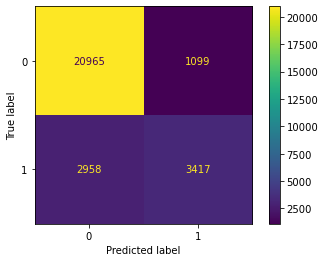

In [45]:
plot_confusion_matrix(lgb, X_test,y_test)

# Feature selection

In [46]:
X = rain.loc[:, rain.columns != 'raintomorrow']
y = rain['raintomorrow']

In [47]:
selector = VarianceThreshold(1.2)
X_train.shape

(113754, 60)

In [48]:
selector.fit_transform(X_train).shape

(113754, 2)

In [49]:
X.loc[:,selector.get_support()].columns

Index(['rainfall', 'distanceToCoast'], dtype='object')

In [50]:
X_train = selector.fit_transform(X_test)
X_test = selector.fit_transform(X_test)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
lgb = LGBMClassifier(max_depth=12, n_estimators=300, colsample_bytree=.7, n_jobs=-1)
results = cross_val_score(lgb, X_train, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

(0.8831733257961595, 0.004763947366289159)

In [52]:
lgb.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.7, max_depth=12, n_estimators=300)

In [53]:
roc_auc_score(y_test, lgb.predict_proba(X_test)[:, 1])

0.884275455359809

# Hyperparameter Tuning

# Conclusion

In [54]:
cvp = cross_val_predict(lgb, X_train, y_train, cv=KFold(10, shuffle=True),method='predict_proba')[:, 1]

In [55]:
threshold1 = cvp > 0.1
threshold2 = cvp > 0.2
threshold3 = cvp > 0.3
threshold4 = cvp > 0.4
threshold5 = cvp > 0.5
threshold6 = cvp > 0.6
threshold7 = cvp > 0.7
threshold8 = cvp > 0.8
threshold9 = cvp > 0.9

Text(0.5, 1.0, '0.9')

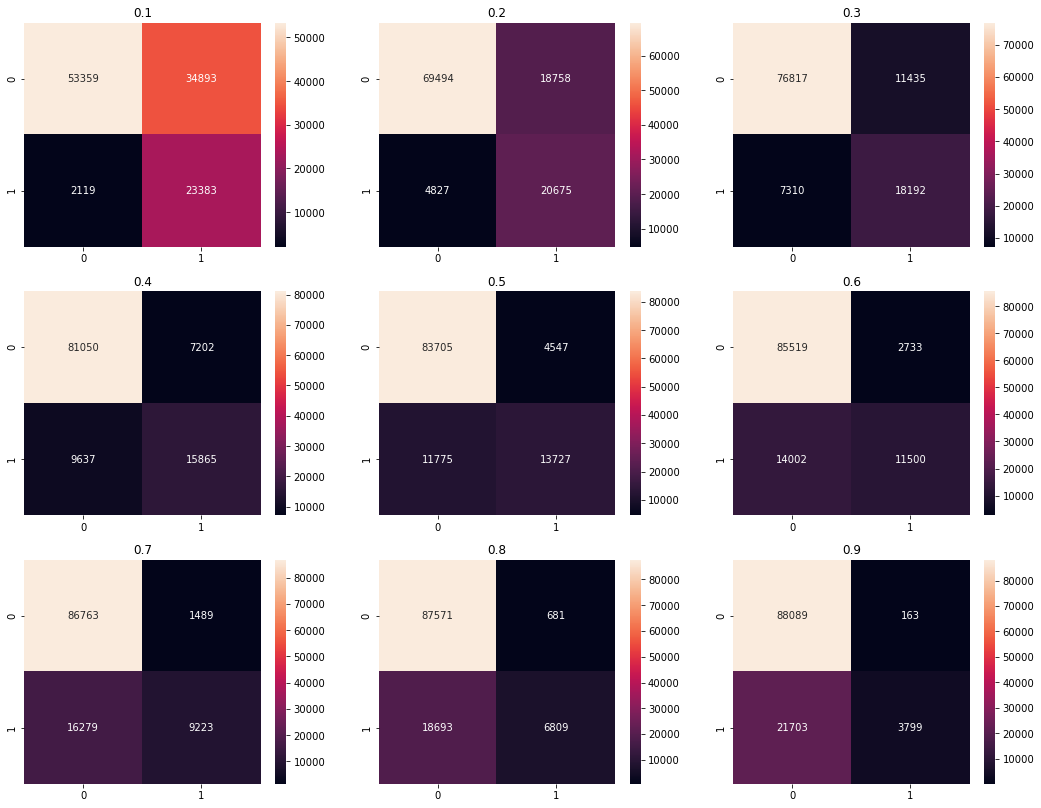

In [56]:
fig, axes = plt.subplots(3,3,figsize=(18,14))
sns.heatmap(confusion_matrix(y_train,threshold1),annot=True,fmt='d',ax=axes[0][0]).set_title('0.1')
sns.heatmap(confusion_matrix(y_train,threshold2),annot=True,fmt='d',ax=axes[0][1]).set_title('0.2')
sns.heatmap(confusion_matrix(y_train,threshold3),annot=True,fmt='d',ax=axes[0][2]).set_title('0.3')
sns.heatmap(confusion_matrix(y_train,threshold4),annot=True,fmt='d',ax=axes[1][0]).set_title('0.4')
sns.heatmap(confusion_matrix(y_train,threshold5),annot=True,fmt='d',ax=axes[1][1]).set_title('0.5')
sns.heatmap(confusion_matrix(y_train,threshold6),annot=True,fmt='d',ax=axes[1][2]).set_title('0.6')
sns.heatmap(confusion_matrix(y_train,threshold7),annot=True,fmt='d',ax=axes[2][0]).set_title('0.7')
sns.heatmap(confusion_matrix(y_train,threshold8),annot=True,fmt='d',ax=axes[2][1]).set_title('0.8')
sns.heatmap(confusion_matrix(y_train,threshold9),annot=True,fmt='d',ax=axes[2][2]).set_title('0.9')

In [57]:
accuracy_score(y_test, lgb.predict_proba(X_test)[:, 1]>0.35)

0.8455641900207461

In [58]:
recall_score(y_test, lgb.predict_proba(X_test)[:, 1]>0.35)

0.6652549019607843

In [59]:
precision_score(y_test, lgb.predict_proba(X_test)[:, 1]>0.35)

0.6525619326050162

In [60]:
#drop nulos
#precipitation drop